In [1]:
#!pip install tqdm wordcloud tensorflow scikit-learn pandas seaborn pydot nltk neal
#!pip install https://cloudos.qboard.tech/qctl-0.0.6-py3-none-any.whl

In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from wordcloud import  WordCloud
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")
test_split = 0.15
validation_split = 0.1
GLOBAL_SEED = 10
num_words=8000
embeddings=128

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Исследование и классическая часть


In [5]:
dataset = pd.read_csv('task-3-dataset.csv')
dataset['разметка'] = dataset['разметка'].map({'-': 0, '+': 1})
dataset.info()
dataset.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   отзывы    210 non-null    object
 1   разметка  210 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


,отзывы,разметка
0,Оболочка после чистого андроида тоже очень нек...,0
1,"Нормальный телефон, очень красивая задняя панель",1
2,Деньги на ветер .,0


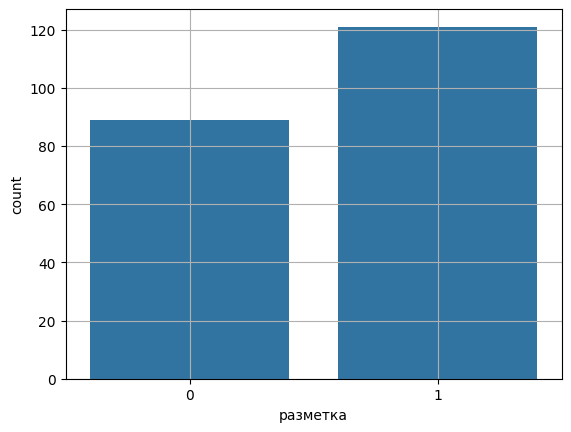

In [6]:
sns.countplot(x=dataset['разметка'])
plt.grid()

In [7]:
import re
from sklearn.metrics import precision_score, recall_score, f1_score 
def clean_sentences(line, stopwords):
    line = line.strip().lower()
    line=re.sub('<.*?>','',line)
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')

    line=re.sub(',',' , ',line)
    line = line.replace(' . . . ', ' ... ')
    line = line.replace('. .', ' ... ')
    for p in stopwords:
        line=re.sub(f' {p} ',' ',line)
    return line

def print_metrics(df_pred, df_true):
    y_true = list(df_true)
    y_pred = list(df_pred)

    print("Precision: ", precision_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("F_1: ", f1_score(y_true, y_pred))
    

## Добавим сгенерированных данных


In [8]:
ad = pd.read_csv('synthetic_data.csv')
dataset = pd.concat([dataset, ad])
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   отзывы    290 non-null    object
 1   разметка  290 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


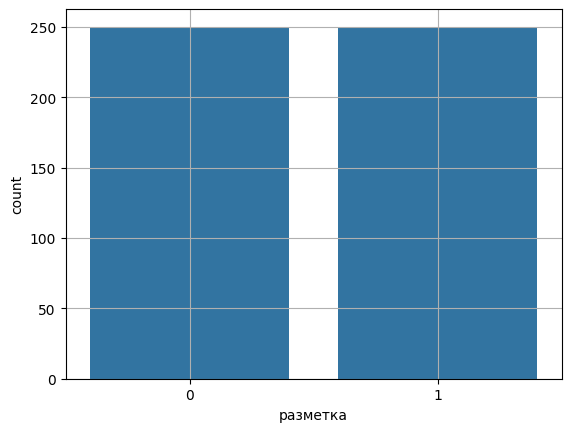

In [9]:
sns.countplot(x=dataset['разметка'])
plt.grid()

## Очистим данные

In [10]:
dataset['отзывы'] = dataset['отзывы'].apply(lambda x: clean_sentences(x,russian_stopwords))

In [11]:
sentences=dataset['отзывы']

pos=' '.join(map(str,sentences[dataset['разметка']==1]))
neg=' '.join(map(str,sentences[dataset['разметка']==0]))

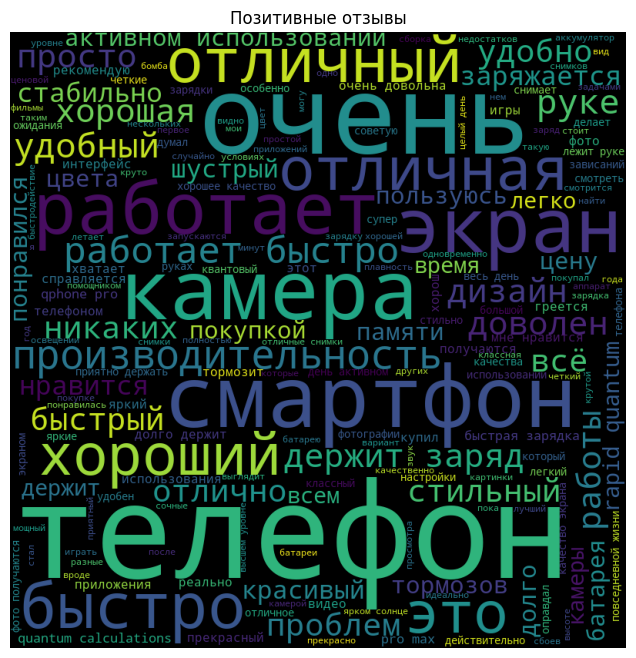

In [12]:
import matplotlib.pyplot as plt
wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(pos)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Позитивные отзывы')
plt.axis('off')
plt.show()

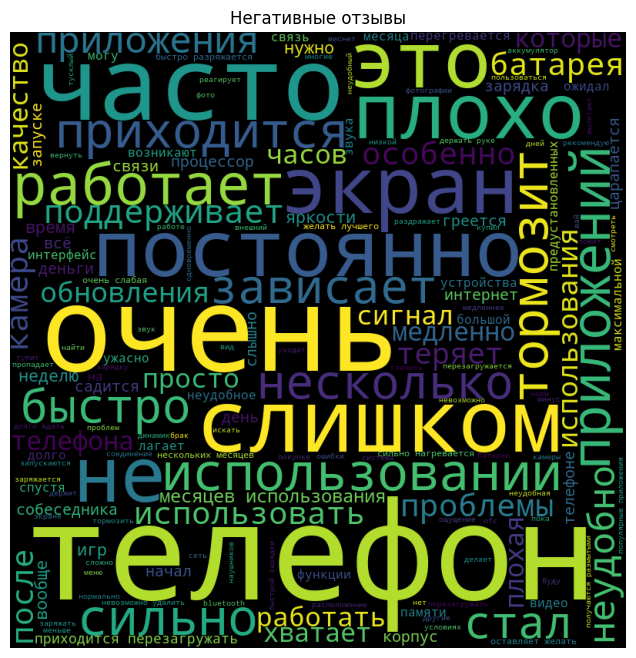

In [13]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(neg)

plt.imshow(wordcloud2)
plt.title('Негативные отзывы')
plt.axis('off')
plt.show()

In [14]:
X_train,X_test,Y_train,Y_test = train_test_split(dataset['отзывы'],dataset['разметка'],test_size=test_split,random_state=GLOBAL_SEED)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=test_split,random_state=GLOBAL_SEED)

## Попробуем глубокие сети

In [15]:
tokenizer=Tokenizer(num_words=num_words,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
total_vocab=len(word_index)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
total_vocab

1367

In [16]:
from keras.preprocessing.sequence import pad_sequences
sequences_train=tokenizer.texts_to_sequences(X_train)
sequences_test=tokenizer.texts_to_sequences(X_test)
sequences_val=tokenizer.texts_to_sequences(X_val)

max_len=max(max([len(x) for x in sequences_train]),max([len(x) for x in sequences_val]))
print(max_len)
X_train=pad_sequences(sequences_train,maxlen=max_len)
X_test=pad_sequences(sequences_test,maxlen=max_len)
X_val=pad_sequences(sequences_val,maxlen=max_len)

36


In [17]:
from tensorflow.keras.models import Model
from keras.layers import Embedding,Activation,LSTM,Flatten,Dense, Input, Dropout

inputs = Input(shape=(max_len,))
x = Embedding(num_words,embeddings, input_shape=(max_len,))(inputs)
x = keras.layers.Bidirectional(LSTM(16,return_sequences=True))(x)
x = LSTM(16)(x)
x = keras.layers.Dropout(0.4)(x)
x = Dense(4,activation='relu')(x)
o2 = Dense(2,activation='softmax', name= 'classic_output')(x)
classic_model = Model(inputs=inputs, outputs=[o2])


C:\Users\alexm\miniconda3\envs\quantnn\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
classic_model.compile(optimizer='adam',
              loss = {'classic_output' : 'binary_crossentropy'},
              metrics = {'classic_output' : 'accuracy'}
             )

In [19]:
classic_model.summary()
tf.keras.utils.plot_model(classic_model, show_shapes=True, show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 36, 128)             │       1,024,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 36, 32)              │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classic_output (Dense)               │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,045,774 (3.99 MB)

 Trainable params: 1,045,774 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [20]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es= EarlyStopping(monitor='val_accuracy',
                  patience=10,
                  mode='max'
                 )

checkpoints=ModelCheckpoint(filepath='./checkpoint.keras',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True
                           )
callbacks=[es,checkpoints]
#history=classic_model.fit(X_train,Y_train,validation_data=(X_val, Y_train),epochs=15,callbacks=callbacks)
history=classic_model.fit(X_train,to_categorical(Y_train,num_classes=2),validation_data=(X_val, to_categorical(Y_val ,num_classes=2)),epochs=25,callbacks=callbacks)

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4797 - loss: 0.6931 - val_accuracy: 0.4844 - val_loss: 0.6930
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4772 - loss: 0.6929 - val_accuracy: 0.6250 - val_loss: 0.6919
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5556 - loss: 0.6899 - val_accuracy: 0.4844 - val_loss: 0.6881
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5148 - loss: 0.6836 - val_accuracy: 0.5000 - val_loss: 0.6747
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5724 - loss: 0.6501 - val_accuracy: 0.6406 - val_loss: 0.6344
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8777 - loss: 0.5691 - val_accuracy: 0.6719 - val_loss: 0.5644
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9197 - loss: 0.4628 - val_accuracy: 0.7656 - val_loss: 0.6395
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9906 - loss: 0.4020 - val_accuracy: 0.8594 - v

In [21]:
classic_model.load_weights('./checkpoint.keras')

In [22]:
classic_model.evaluate(X_test, to_categorical(Y_test,num_classes=2))
classic_model.save('./qnn_model.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8669 - loss: 0.5930  


## большие модели довольно быстро переобучаются на малых данных, попробуем классику

In [23]:
from tensorflow.keras.models import Model
import tensorflow
from tensorflow.keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


russian_stopwords = stopwords.words("russian")

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
MAX_LEN = 36
model = tensorflow.keras.models.load_model('./qnn_model.keras')

def evaluate_text(text, tokenizer, model):
  text = [clean_sentences(text, russian_stopwords)]
  text = pad_sequences(tokenizer.texts_to_sequences(text),maxlen=MAX_LEN)
  output = model.predict(text)
  return output[0].argmax()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
texts = [
    "Телефон обладает отличным качеством сборки и премиальным дизайном.",
    "Камера делает потрясающие снимки даже при низком освещении.",
    "Долговечный аккумулятор позволяет использовать устройство весь день без подзарядки.",

    "Встроенная память недостаточна, а расширение невозможно без облачных сервисов.",
    "После обновления программного обеспечения начались проблемы с производительностью.",
    "Корпус устройства легко собирает царапины и отпечатки пальцев."
]

for t in texts:
  print(evaluate_text(t, tokenizer, model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1


## Предобрабатываем текст и засовываем в SVM

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=2,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True)
x_tfv = tfv.fit_transform(list(dataset['отзывы']))
with open('tfv.pickle', 'wb') as handle:
    pickle.dump(tfv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
from sklearn import preprocessing, decomposition

X_train,X_test,Y_train,Y_test = train_test_split(x_tfv ,dataset['разметка'],test_size=0.15,random_state=GLOBAL_SEED)

svd = decomposition.TruncatedSVD(n_components=310)
svd.fit(X_train)
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)
with open('svd.pickle', 'wb') as handle:
    pickle.dump(svd, handle, protocol=pickle.HIGHEST_PROTOCOL)

scl = preprocessing.StandardScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
with open('scl.pickle', 'wb') as handle:
    pickle.dump(scl, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
from sklearn.svm import SVC

model = SVC(kernel='rbf')
model.fit(X_train,Y_train)
from sklearn.metrics import accuracy_score
y_pred=model.predict(X_test)
with open('model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
print_metrics(y_pred, Y_test)
#print('Model accuracy : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Precision:  0.9473684210526315
Recall:  0.8571428571428571
F_1:  0.9


In [27]:
Y_test.value_counts()

разметка
1    42
0    33
Name: count, dtype: int64

In [28]:
def evaluate_text(texts, tfv, svd, scl, model):
  text = [clean_sentences(t, russian_stopwords) for t in texts]
  text = scl.transform(svd.transform(tfv.transform(text)))
  output = model.predict(text)
  return output

with open('tfv.pickle', 'rb') as handle:
    tfv = pickle.load(handle)
with open('svd.pickle', 'rb') as handle:
    svd = pickle.load(handle)
with open('scl.pickle', 'rb') as handle:
    scl = pickle.load(handle)
with open('model.pickle', 'rb') as handle:
    model = pickle.load(handle)    
print(evaluate_text(texts, tfv, svd, scl, model))

[1 1 1 0 0 0]


In [29]:
dataset = pd.read_csv('task-3-dataset.csv')
dataset['разметка'] = dataset['разметка'].map({'-': 0, '+': 1})

print('Model accuracy : {0:0.4f}'. format(accuracy_score(evaluate_text(dataset['отзывы'], tfv, svd, scl, model), dataset['разметка'])))

Model accuracy : 0.9810


# квантовая часть


In [30]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

russian_stopwords = stopwords.words("russian")
test_split = 0.1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Подготовка данных та же


In [31]:
import re
from sklearn import preprocessing, decomposition
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_sentences(line, stopwords):
    line = line.strip().lower()
    line=re.sub('<.*?>','',line)
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
    line=re.sub(',',' , ',line)
    line = line.replace(' . . . ', ' ... ')
    line = line.replace('. .', ' ... ')
    for p in stopwords:
        line=re.sub(f' {p} ',' ',line)
    return line

dataset = pd.read_csv('task-3-dataset.csv')
dataset['разметка'] = dataset['разметка'].map({'-': 0, '+': 1})
ad = pd.read_csv('synthetic_data.csv')
dataset = pd.concat([dataset, ad])
dataset['отзывы'] = dataset['отзывы'].apply(lambda x: clean_sentences(x,russian_stopwords))
tfv = TfidfVectorizer(min_df=2,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True)
x_tfv = tfv.fit_transform(list(dataset['отзывы']))

X_train,X_test,Y_train,Y_test = train_test_split(x_tfv ,dataset['разметка'],test_size=test_split,random_state=GLOBAL_SEED)

svd = decomposition.TruncatedSVD(n_components=310)
svd.fit(X_train)
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)
with open('svd.pickle', 'wb') as handle:
    pickle.dump(svd, handle, protocol=pickle.HIGHEST_PROTOCOL)

scl = preprocessing.StandardScaler()
scl.fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
with open('scl.pickle', 'wb') as handle:
    pickle.dump(scl, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
X_train_qubo = np.asarray(X_train)
N = X_train_qubo.shape[0]
X_train_qubo = np.concatenate((np.ones((N, 1)), X_train_qubo), axis=1)
Y_qubo = np.asarray(Y_train)
Y_qubo = 2 * Y_qubo - 1
Y_qubo = Y_qubo.reshape((-1, 1))
np.save('X_train_qubo.npy', X_train_qubo)
np.save('Y_qubo.npy', Y_qubo)

## После этого мы переносим значения на QBoard и запускаем следующий скрипт:

In [33]:
from time import time
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import random
from scipy import stats
import pickle
import pyqiopt as pq

start = time()
X_train_qubo = np.load('/workspace/Task3/X_train_qubo.npy')
Y_qubo = np.load('/workspace/Task3/Y_qubo.npy')
N = X_train_qubo.shape[0]
m = -25
l = 0
P = 2.**np.arange(m, l + 1)
P_cal = np.kron(np.diag(np.ones(N)), P.T)
Q = 1/2 * P_cal.T @ (((X_train_qubo@X_train_qubo.T) * (Y_qubo@Y_qubo.T))) @ P_cal - np.diag(P_cal.T @ np.ones(N))
print(Q.shape)
eps = 10**(-6)
Q[abs(Q)<eps]=0
arr_sp = coo_matrix(Q) 
sol = pq.solve(Q, number_of_runs=200, number_of_steps=150, return_samples=False, verbose=10, gpu =True, sigma=3)
print(sol.vector, sol.objective)
v = np.asarray(sol.vector)
print("Script time:", time()-start)
np.save('/workspace/Task3/qsvm.npy', v)

ModuleNotFoundError: No module named 'pyqiopt'

## Но можно и локально:

In [34]:
m = -20
l = 0

P = 2.**np.arange(m, l + 1)
P_cal = np.kron(np.diag(np.ones(N)), P.T)

Q = 1/2 * P_cal.T @ (((X_train_qubo@X_train_qubo.T) * (Y_qubo@Y_qubo.T))) @ P_cal - np.diag(P_cal.T @ np.ones(N))
print(Q.shape)

(9450, 9450)


In [35]:
eps = 10**(-5)
Q[abs(Q)<eps]=0
Q

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.88363399e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.83301353e+00, 1.61660271e+01, 3.23320541e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.61660271e+01, 3.18320541e+01, 6.46641082e+01],
       [0.00000000e+00, 0.00000000e+00, 1.88363399e-05, ...,
        3.23320541e+01, 6.46641082e+01, 1.28328216e+02]])

In [36]:
import neal
def solve_qubo(Q):
    sampler = neal.SimulatedAnnealingSampler()
    response = sampler.sample_qubo(Q, num_reads=15)
    best_solution = response.first.sample
    return best_solution

In [37]:
Lambda_cal = solve_qubo(Q)
Lambda_cal = np.asarray(list(Lambda_cal.values()), dtype=np.int32).reshape(-1, 1)
np.save('qsvm.npy', Lambda_cal)

## Далее уже локально из полученных файлов

In [38]:
Lambda_cal = np.load('qsvm.npy').reshape(-1, 1)
m = -20
l = 0
P = 2.**np.arange(m, l + 1)
P_cal = np.kron(np.diag(np.ones(N)), P.T)
X_train_qubo = np.load('X_train_qubo.npy')
Y_qubo = np.load('Y_qubo.npy')

In [39]:
Lambda = P_cal @ Lambda_cal
w = X_train_qubo.T @ (Lambda * Y_qubo)
X_train_qubo.shape

(450, 311)

In [40]:
X = np.asarray(X_test)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = X @ w
res = np.sign(y)
res = (res + 1) / 2

results = res.astype(int).reshape((1, -1))[0]
print_metrics(results, Y_test)

Precision:  0.8148148148148148
Recall:  0.7096774193548387
F_1:  0.7586206896551724


## Тестовые данные

In [44]:
dataset = pd.read_csv('test50.csv')
dataset['разметка'] = dataset['разметка'].map({'-': 0, '+': 1})
dataset.info()
dataset.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Отзывы    50 non-null     object
 1   разметка  50 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 928.0+ bytes


,Отзывы,разметка
0,"Очень разочарован QPhone. Ожидал, что квантовы...",0
1,Очень быстро разряжается. Просто полное разоча...,0
2,"Ну что тут сказать, телефон хороший, флагман т...",1


In [46]:
#dataset['отзывы'] = dataset['отзывы'].apply(lambda x: clean_sentences(x,russian_stopwords))
test50 = [clean_sentences(t, russian_stopwords) for t in dataset['Отзывы']]
test50 = scl.transform(svd.transform(tfv.transform(test50)))

In [47]:
X = np.asarray(test50)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = X @ w
res = np.sign(y)
res = (res + 1) / 2

results = res.astype(int).reshape((1, -1))[0]
print('Model accuracy : {0:0.4f}'. format(accuracy_score(results, dataset['разметка'])))

Model accuracy : 0.7000
